In [1]:
# Importing the dpendancies

import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
from cuml.model_selection import GridSearchCV

%matplotlib inline


In [2]:
# Read the data 

data = pd.read_csv('/home/ali/Cellula/Task_5/final_internship_data.csv')

In [3]:
# Check data shape

data.shape

(500000, 26)

In [4]:
# Checking for duplicate data and dropping them

print(sum(data.duplicated()))
data.drop_duplicates(inplace = True)

0


In [5]:
# Dropping coasting features 

data.drop(columns = ['User ID', 'User Name', 'Driver Name', 'key', 'pickup_datetime'], axis = 1 , inplace = True)

In [6]:
# Function to count the total number of negative values in a specified features

def count_negative_values(df, column_name):

    if column_name in df.columns:
        return (df[column_name] < 0).sum()
    else:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")


In [7]:
# Check for negative values in specific features

features = ['fare_amount', 'distance']

for feature in features :
    negative_count = count_negative_values(data, feature)
    print('the total number of negative values in feature {} is : {} '.format(feature, negative_count))


the total number of negative values in feature fare_amount is : 21 
the total number of negative values in feature distance is : 0 


In [8]:
# Drop negative values

data.drop(data[data['fare_amount'] < 0].index, inplace=True)

In [9]:
# Illustration for categorical features

features = ['Car Condition', 'Weather', 'Traffic Condition', 'passenger_count', 'hour', 'day', 'month', 'weekday', 'year']

for feature in features :
    print(data[feature].value_counts())
    print("\n")

Car Condition
Very Good    125310
Bad          124968
Good         124962
Excellent    124739
Name: count, dtype: int64


Weather
sunny     100426
cloudy    100058
rainy      99970
stormy     99950
windy      99575
Name: count, dtype: int64


Traffic Condition
Congested Traffic    166840
Dense Traffic        166580
Flow Traffic         166559
Name: count, dtype: int64


passenger_count
1    345994
2     73907
5     35321
3     21759
4     10613
6     10589
0      1796
Name: count, dtype: int64


hour
19    31381
18    30064
20    29193
21    28639
22    27816
14    25384
23    24862
12    24650
17    24646
13    24403
15    24024
9     23565
11    23338
8     22598
10    22426
16    20569
0     19648
7     18230
1     14553
2     10883
6     10326
3      7936
4      5864
5      4981
Name: count, dtype: int64


day
13    17244
12    17172
16    17088
11    17039
9     16961
15    16957
20    16909
18    16905
19    16887
17    16882
21    16872
8     16807
14    16794
10    16761
23    

In [10]:
# Label encode categorical features

custom_mapping_car = {'Very Good': 2, 'Bad': 0, 'Good': 1, 'Excellent': 3}
data['Car Condition']= data['Car Condition'].map(custom_mapping_car)

custom_mapping_weather = {'sunny': 4, 'cloudy': 3, 'rainy': 1, 'stormy': 0, 'windy': 2}
data['Weather']= data['Weather'].map(custom_mapping_weather)

custom_mapping_traffic = {'Congested Traffic': 0, 'Dense Traffic': 1, 'Flow Traffic': 2}
data['Traffic Condition']= data['Traffic Condition'].map(custom_mapping_traffic)

In [11]:
# Checking if any data is missing

print(data.isnull().sum())

Car Condition        0
Weather              0
Traffic Condition    0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
hour                 0
day                  0
month                0
weekday              0
year                 0
jfk_dist             5
ewr_dist             5
lga_dist             5
sol_dist             5
nyc_dist             5
distance             5
bearing              5
dtype: int64


In [12]:
# Dropping missing data

data = data.dropna()
data.shape

(499974, 21)

In [13]:
# Function to detect outliers

def detect_outliers(df, column_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    # Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1
    # Define the lower and upper bounds for the data
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    no_of_outliers = sum((df[column_name] < lower_bound) | (df[column_name] > upper_bound))
    return no_of_outliers

In [14]:
# Detect outliers in specific features

features_outlier = ['bearing', 'fare_amount', 'distance']

for feature in features_outlier:
    print('Number of outliers in column {} is : {}'.format(feature, detect_outliers(data, feature)))

Number of outliers in column bearing is : 0
Number of outliers in column fare_amount is : 43320
Number of outliers in column distance is : 41923


In [15]:
# Handleing outliers with log transformation

data['fare_amount'] = data['fare_amount'].apply(lambda x: np.log(x) if x > 0 else 0)
data['distance'] = data['distance'].apply(lambda x: np.log(x) if x > 0 else 0)

In [16]:
# Function to calculate VIF

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # Keep only numeric features
    numeric_df = df.select_dtypes(include=[float, int])
    vif_data = pd.DataFrame()
    vif_data['feature'] = numeric_df.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
    return vif_data

vif_df = calculate_vif(data.drop(columns = ['fare_amount'], axis = 1))
print(vif_df)


              feature           VIF
0       Car Condition  2.800872e+00
1             Weather  3.001101e+00
2   Traffic Condition  2.498053e+00
3    pickup_longitude  2.296457e+02
4     pickup_latitude  6.661436e+01
5   dropoff_longitude  3.660448e+02
6    dropoff_latitude  2.564213e+02
7     passenger_count  2.663447e+00
8                hour  5.363515e+00
9                 day  4.265869e+00
10              month  4.325949e+00
11            weekday  3.477150e+00
12               year  1.949899e+03
13           jfk_dist  4.012931e+05
14           ewr_dist  3.706869e+06
15           lga_dist  4.323959e+05
16           sol_dist  2.056432e+07
17           nyc_dist  1.079054e+07
18           distance  1.825787e+00
19            bearing  1.039413e+00


In [17]:
# Using PCA to handle multicollinearty problem

from sklearn.decomposition import PCA

data_pca_1 = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist']]
data_pca_2 = data[['hour', 'year']]
pca_1 = PCA(n_components = 3)
pca_2 = PCA(n_components = 1)
pc_1 = pca_1.fit_transform(data_pca_1)
pc_2 = pca_2.fit_transform(data_pca_2)
data['PC1'] = pc_1[:, 0]
data['PC2'] = pc_1[:, 1]
data['PC3'] = pc_1[:, 2]
data['PC4'] = pc_2

In [18]:
# Dropping multicollinearity features 

data.drop(columns = ['hour', 'year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist', 'nyc_dist'], axis = 1 , inplace = True)

In [19]:
# Calculate VIF again

vif_df = calculate_vif(data.drop(columns = ['fare_amount'], axis = 1))
print(vif_df)

              feature       VIF
0       Car Condition  2.515622
1             Weather  2.655361
2   Traffic Condition  2.282892
3     passenger_count  2.444469
4                 day  3.459230
5               month  3.482173
6             weekday  3.023135
7            distance  1.711284
8             bearing  1.036869
9                 PC1  1.003020
10                PC2  1.052008
11                PC3  1.043300
12                PC4  1.009154


In [20]:
# Forming the data

X = data.drop(columns = ['fare_amount'], axis = 1)
Y = data['fare_amount']

In [21]:
# Forming train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [22]:
# Data Standrization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Makeing data suitable for GPU 

import cupy as cp

X_train_gpu = cp.asarray(X_train)
Y_train_gpu = cp.asarray(Y_train)
X_test_gpu = cp.asarray(X_test)
Y_test_gpu = cp.asarray(Y_test)

In [24]:
# Importing evaluation metrics

from cuml.metrics import r2_score
from cuml.metrics import mean_absolute_error
from cuml.metrics import mean_squared_error

def gpu_r2_scorer(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    return r2_score(y_test, y_pred)

In [ ]:
# KNN model

from cuml.neighbors import KNeighborsRegressor

class KNeighborsRegressorWrapper(KNeighborsRegressor):
    def __init__(self, *args, **kwargs):
        # Remove n_jobs if present
        if 'n_jobs' in kwargs:
            kwargs.pop('n_jobs')
        super().__init__(*args, **kwargs)

knn_regressor = KNeighborsRegressorWrapper(algorithm = 'brute')

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform'],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(estimator = knn_regressor, param_grid = param_grid, scoring = gpu_r2_scorer, cv = 5, verbose = 1)
grid_search.fit(X_train_gpu, Y_train_gpu)
Best_KNN_model = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
# Various scores for KNN model

y_preds_KNN = Best_KNN_model.predict(X_test_gpu)
mse_KNN = mean_squared_error(Y_test_gpu, y_preds_KNN)
rmse_KNN = np.sqrt(mse_KNN)
mae_KNN = mean_absolute_error(Y_test_gpu, y_preds_KNN)
r2_score_KNN = r2_score(Y_test_gpu, y_preds_KNN)
print(mse_KNN, rmse_KNN, mae_KNN, r2_score_KNN)

0.10474234990011981 0.32363922799951156 0.23018845802493487 0.7123495883698144


In [ ]:
# SVR model

from cuml.svm import SVR

SVR_model = SVR(
    C = 1.0,              
    kernel = 'linear',     
    epsilon = 0.1,         
    tol = 0.001,           
    cache_size = 4000,     
    max_iter = -1          
)
SVR_model.fit(X_train_gpu, Y_train_gpu)

In [ ]:
# Various scores for SVR model

y_preds_SVR = SVR_model.predict(X_test_gpu)
mse_SVR = mean_squared_error(Y_test_gpu, y_preds_SVR)
rmse_SVR = np.sqrt(mse_SVR)
mae_SVR = mean_absolute_error(Y_test_gpu, y_preds_SVR)
r2_score_SVR = r2_score(Y_test_gpu, y_preds_SVR)
print(mse_SVR, rmse_SVR, mae_SVR, r2_score_SVR)

3.085337808446991 1.7565129684824394 1.44092191126834 -7.473160010867165


In [ ]:
# Saving model after training

pickle.dump(SVR_model, open('model_SVR.pkl', 'wb'))

In [ ]:
# Linear regression model

from cuml.linear_model import LinearRegression

Linear_model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
}
grid_search = GridSearchCV(estimator = Linear_model, param_grid = param_grid, cv = 5, scoring = gpu_r2_scorer, verbose = 1)
grid_search.fit(X_train_gpu, Y_train_gpu)
Best_Linear_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
# Various scores for Linear regression model

y_preds_linear = Best_Linear_model.predict(X_test_gpu)
mse_linear = mean_squared_error(Y_test_gpu, y_preds_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(Y_test_gpu, y_preds_linear)
r2_score_linear = r2_score(Y_test_gpu, y_preds_linear)
print(mse_linear, rmse_linear, mae_linear, r2_score_linear)

0.16677013366957646 0.40837499148402373 0.2691118155319384 0.5420047607923691


In [ ]:
# XGB Regressor model

from xgboost import XGBRegressor

xgb_reg = XGBRegressor(objective = 'reg:squarederror', device = 'cuda')
param_grid = {
    'n_estimators': [500, 1000],        
    'max_depth': [10, 15],                
    'learning_rate': [0.05, 0.1],      
    'subsample': [0.8, 1.0],            
    'colsample_bytree': [0.8, 1.0],     
    'min_child_weight': [5, 10],          
    'gamma': [0.1, 0.3],                  
    'reg_alpha': [0.01, 0.1],             
    'reg_lambda': [1.5, 2]                
}
grid_search = GridSearchCV(estimator = xgb_reg, param_grid = param_grid, cv = 3, scoring = gpu_r2_scorer, verbose = 1)
grid_search.fit(X_train_gpu, Y_train_gpu)
Best_XGB_model = grid_search.best_estimator_

Fitting 3 folds for each of 512 candidates, totalling 1536 fits


In [ ]:
# Saving model after training

pickle.dump(Best_XGB_model, open('model_XGB.pkl', 'wb'))

In [ ]:
# Load model for predicition

Best_XGB_model = pickle.load(open('model_XGB.pkl','rb'))

In [ ]:
# Various scores for XGB Regressor model

y_preds_XGB = Best_XGB_model.predict(X_test_gpu)
mse_XGB = mean_squared_error(Y_test_gpu, y_preds_XGB)
rmse_XGB = np.sqrt(mse_XGB)
mae_XGB = mean_absolute_error(Y_test_gpu, y_preds_XGB)
r2_score_XGB = r2_score(Y_test_gpu, y_preds_XGB)
print(mse_XGB, rmse_XGB, mae_XGB, r2_score_XGB)

0.0642602709538529 0.2534960965258694 0.14973687407689137 0.8235241675504752


In [ ]:
# Random forest regressor model

from cuml.ensemble import RandomForestRegressor

rf_gpu = RandomForestRegressor(random_state = 42, n_streams = 1)

param_grid = {
    'n_estimators': [100, 150],        
    'max_depth': [10, 15],              
    'max_features': [0.3, 0.5],        
    'min_samples_split': [10],        
    'min_samples_leaf': [4]          
}

grid_search = GridSearchCV(estimator = rf_gpu, param_grid = param_grid, cv = 3, scoring = gpu_r2_scorer, verbose = 1)
grid_search.fit(X_train_gpu, Y_train_gpu)
Best_forest_model = grid_search.best_estimator_

In [ ]:
# Various scores for Random forest Regressor model

y_preds_forest = Best_forest_model.predict(X_test_gpu)
mse_forest = mean_squared_error(Y_test_gpu, y_preds_forest)
rmse_forest = np.sqrt(mse_forest)
mae_forest = mean_absolute_error(Y_test_gpu, y_preds_forest)
r2_score_forest = r2_score(Y_test_gpu, y_preds_forest)
print(mse_forest, rmse_forest, mae_forest, r2_score_forest)

0.07496387378950196 0.2737953136733753 0.1767143939483601 0.7941292211459269


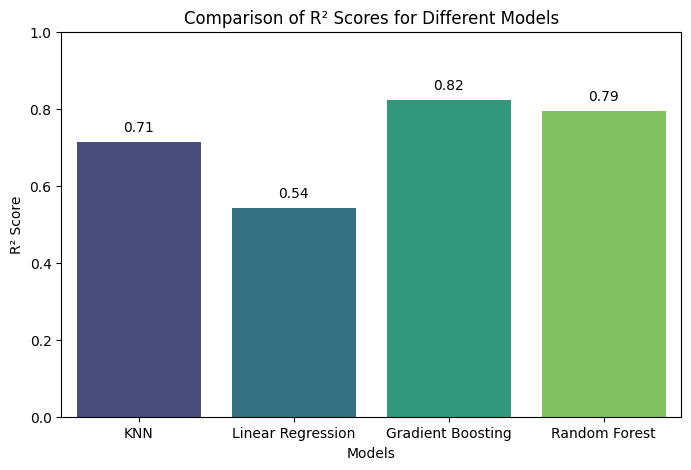

In [ ]:
# Comparison of R² Scores for Different Models

import matplotlib.pyplot as plt
import seaborn as sns

models = ['KNN','SVR', 'Linear Regression', 'Gradient Boosting', 'Random Forest']
r2_scores = [r2_score_KNN, r2_score_SVR, r2_score_linear, r2_score_XGB, r2_score_forest]  

plt.figure(figsize=(8, 5))
sns.barplot(x = models, y = r2_scores, hue = models, legend = False, palette = 'viridis')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores for Different Models')
plt.ylim(0, 1) 


for i, score in enumerate(r2_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha = 'center', va = 'bottom')


plt.show()

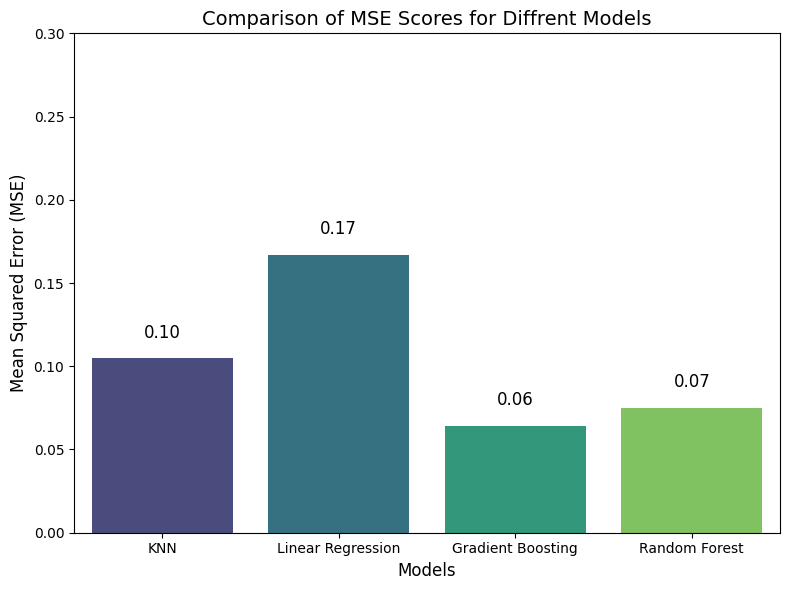

In [ ]:
# Comparison of MSE Scores for Diffrent Models

models = ['KNN','SVR', 'Linear Regression', 'Gradient Boosting', 'Random Forest']
mse_scores = [mse_KNN, mse_SVR, mse_linear, mse_XGB, mse_forest]


plt.figure(figsize = (8, 6))
sns.barplot(x = models, y = mse_scores, hue = models, legend = False,  palette = 'viridis')

# Add labels and title
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Mean Squared Error (MSE)', fontsize = 12)
plt.title('Comparison of MSE Scores for Diffrent Models', fontsize = 14)
plt.ylim(0, 0.3)

# Add data labels on top of bars
for i, score in enumerate(mse_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha = 'center', va = 'bottom', fontsize = 12)

# Show the plot
plt.tight_layout()
plt.show()

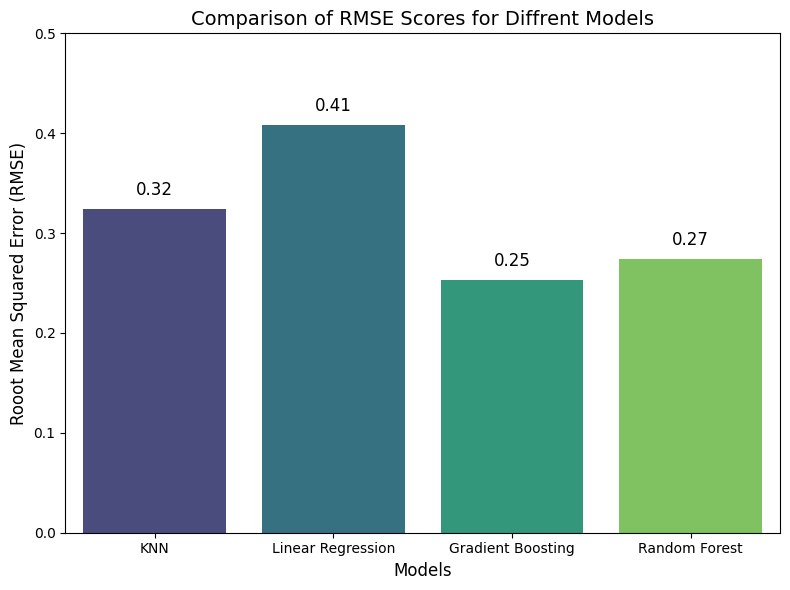

In [ ]:
# Comparison of RMSE Scores for Diffrent Models

models = ['KNN','SVR', 'Linear Regression', 'Gradient Boosting', 'Random Forest']
rmse_scores = [rmse_KNN, rmse_SVR, rmse_linear, rmse_XGB, rmse_forest]


plt.figure(figsize = (8, 6))
sns.barplot(x = models, y = rmse_scores, hue = models, legend = False, palette = 'viridis')

# Add labels and title
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Rooot Mean Squared Error (RMSE)', fontsize = 12)
plt.title('Comparison of RMSE Scores for Diffrent Models', fontsize = 14)
plt.ylim(0, 0.5)

# Add data labels on top of bars
for i, score in enumerate(rmse_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha = 'center', va = 'bottom', fontsize = 12)

# Show the plot
plt.tight_layout()
plt.show()

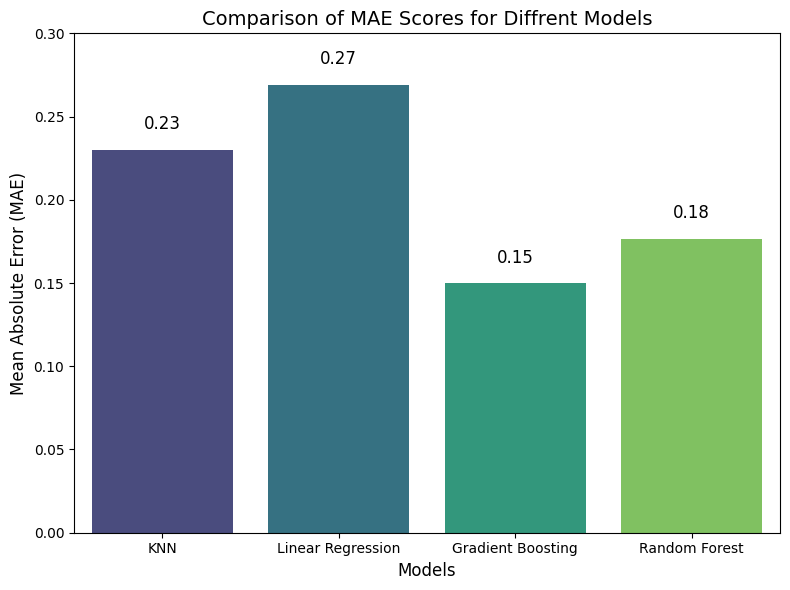

In [ ]:
# Comparison of MAE Scores for Diffrent Models

models = ['KNN','SVR', 'Linear Regression', 'Gradient Boosting', 'Random Forest']
mae_scores = [mae_KNN, mae_SVR, mae_linear, mae_XGB, mae_forest]


plt.figure(figsize = (8, 6))
sns.barplot(x = models, y = mae_scores, hue = models, legend = False, palette = 'viridis')

# Add labels and title
plt.xlabel('Models', fontsize = 12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize = 12)
plt.title('Comparison of MAE Scores for Diffrent Models', fontsize = 14)
plt.ylim(0, 0.3)

# Add data labels on top of bars
for i, score in enumerate(mae_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha = 'center', va = 'bottom', fontsize = 12)

# Show the plot
plt.tight_layout()
plt.show()